In [1]:
import urllib.request
import zipfile

# Download GloVe embeddings
url = "https://nlp.stanford.edu/data/glove.6B.zip"
urllib.request.urlretrieve(url, "glove.6B.zip")

# Unzip
with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall()

# You can use glove.6B.50d.txt (50 dimensions)
# or glove.6B.100d.txt (100 dimensions)

In [17]:
from collections import Counter
from collections import Counter
from typing import List, Dict, Tuple, Union
import re

# Assuming the tokenize function is defined elsewhere
def tokenize(text):
    # Tokenization logic, removing HTML and stopwords as discussed earlier
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    tokens = cleaned_text.lower().split()
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return filtered_tokens

def tokenize_glove_style(text):
    """
    Tokenize text to match GloVe's preprocessing
    """
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert to lowercase
    text = text.lower()

    # Replace numbers with '0'
    text = re.sub(r'\d', '0', text)

    # Split on whitespace and punctuation
    # GloVe keeps punctuation as separate tokens
    text = re.sub(r'([.,!?()])', r' \1 ', text)
    text = re.sub(r'\s{2,}', ' ', text)

    return text.split()

def build_vocab(sentences, max_vocab_size=10000):
    counter = Counter()
    for text in sentences:
        counter.update(tokenize(text))

    # Take only the top max_vocab_size-1 most frequent words (leave room for special tokens)
    most_common = counter.most_common(max_vocab_size - 2)  # -2 for <pad> and <unk>

    # Create vocabulary with indices starting from 2
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<pad>'] = 0  # Add padding token
    vocab['<unk>'] = 1  # Add unknown token
    return vocab

# When building vocabulary:
def build_vocab_glove(sentences, max_vocab_size=10000):
    counter = Counter()
    for text in sentences:
        counter.update(tokenize_glove_style(text))

    # Take most frequent words
    most_common = counter.most_common(max_vocab_size - 2)

    # Create vocabulary with indices starting from 2
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1

    return vocab

def texts_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        sequence = []
        for word in tokenize_glove_style(sentence):
            # Use unknown token (1) for words not in vocabulary
            sequence.append(word_index.get(word, 1))
        sequences.append(sequence)
    return sequences

def pad_sequences(sequences, max_len):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_seq = seq[:max_len]
        else:
            padded_seq = seq + [0] * (max_len - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences

def word_frequency(sentences, word_dict):
    frequency = {word: 0 for word in word_dict}

    for sentence in sentences:
        words = sentence.lower().split()
        for word in words:
            if word in frequency:
                frequency[word] += 1

    return frequency

def word_frequency_glove(sentences, vocab=None):
    """
    Count word frequencies in sentences and return sorted results
    Args:
        sentences: List of sentences
        vocab: Optional vocabulary to filter words (if None, count all words)
    Returns:
        List of tuples (word, count) sorted by count in descending order
    """
    counter = Counter()

    # Count frequencies using the same tokenization
    for sentence in sentences:
        tokens = tokenize_glove_style(sentence)
        counter.update(tokens)

    # If vocab is provided, only keep words in vocab
    if vocab is not None:
        counter = Counter({word: count for word, count in counter.items() if word in vocab})

    # Sort by frequency (descending) and then alphabetically for ties
    sorted_words = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    return sorted_words


In [3]:
# Handling Stop Words
import json


from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

#import matplotlib.pyplot as plt
#plt.plot(xs,newys)
#plt.axis([20000, 27000, 50, 250])
#plt.show()

#print(newys[20000])





--2024-10-30 14:34:05--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.251, 172.217.164.27, 172.217.0.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2024-10-30 14:34:06 (100 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



<ipython-input-4-f2daca70d7b3>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [27]:
vocab_size = 8000
max_length = 60
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Updated for vocab size limitation
word_index = build_vocab_glove(training_sentences, max_vocab_size=vocab_size)
training_sequences = texts_to_sequences(training_sentences, word_index)
training_padded = pad_sequences(training_sequences, max_len=max_length)


testing_sequences = texts_to_sequences(testing_sentences, word_index)
testing_padded = pad_sequences(testing_sequences, max_len=max_length)

#word_freq = word_frequency(training_sentences, word_index)
#print(word_freq)

# Example usage:
word_freq = word_frequency_glove(sentences, word_index)

print(word_freq)


[('00', 1704), ('0', 1634), ('new', 1523), ('trump', 1295), ('man', 1266), ('not', 738), ('just', 579), ('will', 558), ('000', 546), ('one', 540), ('report', 514), ('year', 513), ('area', 490), ('donald', 472), ('u', 470), ('day', 465), ('s', 462), ('0000', 460), ('says', 453), ('can', 445), ('woman', 444), ('first', 435), ('time', 433), ('no', 413), ('like', 407), ('get', 397), ('trumps', 391), ('old', 387), ('off', 383), ('people', 377), ('life', 376), ('obama', 362), ('now', 361), ('house', 351), ('make', 333), ('still', 332), ('white', 329), ('women', 329), ('back', 326), ('clinton', 309), ('world', 291), ('years', 285), ('family', 275), ('americans', 271), ('black', 267), ('way', 266), ('american', 250), ('gop', 249), ('study', 248), ('school', 247), ('best', 244), ('bill', 241), ('police', 234), ('show', 234), ('watch', 233), ('really', 230), ('last', 227), ('cant', 225), ('home', 225), ('know', 224), ('death', 223), ('president', 220), ('good', 219), ('things', 217), ('state', 2

In [33]:
import numpy as np
import torch
import torch.nn as nn
import urllib.request
import zipfile
import os
import torch.optim as optim


def load_pretrained_embeddings(vocab, embedding_dim=100):
    """
    Load GloVe embeddings for words in vocabulary
    """

    embeddings_dict = {}
    glove_file = f'glove.6B.{embedding_dim}d.txt'

    # Read GloVe embeddings
    print(f"Loading GloVe embeddings from {glove_file}...")
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector

    # Initialize embedding matrix
    embedding_matrix = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim))

    # Special tokens
    embedding_matrix[0] = np.zeros(embedding_dim)  # <pad>

    # Fill with pretrained embeddings
    found_words = 0
    for word, idx in vocab.items():
        if word in embeddings_dict:
            embedding_matrix[idx] = embeddings_dict[word]
            found_words += 1

    print(f"Found embeddings for {found_words}/{len(vocab)} words")
    return torch.FloatTensor(embedding_matrix)

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=16, dropout_rate=0.25,
                 pretrained_embeddings=None, freeze_embeddings=True):
        super(TextClassificationModel, self).__init__()

        # Initialize embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Load pretrained embeddings if provided
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(2)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

def create_model(vocab, device='cuda', embedding_dim=100):
    # Load pretrained embeddings
    pretrained_embeddings = load_pretrained_embeddings(vocab, embedding_dim)

    # Create model with pretrained embeddings
    model = TextClassificationModel(
        vocab_size=len(vocab),
        embedding_dim=embedding_dim,
        hidden_dim=16,
        pretrained_embeddings=pretrained_embeddings,
        freeze_embeddings=True  # Set to False if you want to fine-tune embeddings
    ).to(device)

    return model

# Usage example:

# Create model with GloVe embeddings
model = create_model(
    vocab=word_index,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    embedding_dim=50  # Can be 50, 100, 200, or 300
)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), amsgrad=False)


Loading GloVe embeddings from glove.6B.50d.txt...
Found embeddings for 7939/8000 words


In [34]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Assuming your TextClassificationModel is already defined

# Convert your preprocessed data to PyTorch tensors
training_padded = torch.tensor(training_padded, dtype=torch.long)
testing_padded = torch.tensor(testing_padded, dtype=torch.long)
training_labels = torch.tensor(training_labels, dtype=torch.float32)
testing_labels = torch.tensor(testing_labels, dtype=torch.float32)

# Create DataLoader objects
batch_size = 32
train_dataset = TensorDataset(training_padded, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(testing_padded, testing_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Training loop
num_epochs = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += targets.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            val_loss += loss.item()
            val_total += targets.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}:')
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_correct/train_total)
    val_loss_history.append(val_loss/len(test_loader))
    val_acc_history.append(val_correct/val_total)
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_correct/train_total:.4f}')
    print(f'Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_correct/val_total:.4f}')

# After training, you can save the model
torch.save(model.state_dict(), 'text_classification_model.pth')

<ipython-input-34-e77db91b8376>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_padded = torch.tensor(training_padded, dtype=torch.long)
<ipython-input-34-e77db91b8376>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_padded = torch.tensor(testing_padded, dtype=torch.long)
<ipython-input-34-e77db91b8376>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_labels = torch.tensor(training_labels, dtype=torch.float32)
<ipython-input-34-e77db91b8376>:13: UserWarning: To copy construct from a tensor, it is recommended

Epoch 1/300:
Train Loss: 0.6859, Train Acc: 0.5603
Val Loss: 0.6835, Val Acc: 0.5633
Epoch 2/300:
Train Loss: 0.6818, Train Acc: 0.5603
Val Loss: 0.6794, Val Acc: 0.5633
Epoch 3/300:
Train Loss: 0.6773, Train Acc: 0.5603
Val Loss: 0.6749, Val Acc: 0.5634
Epoch 4/300:
Train Loss: 0.6722, Train Acc: 0.5619
Val Loss: 0.6699, Val Acc: 0.5701
Epoch 5/300:
Train Loss: 0.6666, Train Acc: 0.5774
Val Loss: 0.6646, Val Acc: 0.5895
Epoch 6/300:
Train Loss: 0.6606, Train Acc: 0.5996
Val Loss: 0.6590, Val Acc: 0.6117
Epoch 7/300:
Train Loss: 0.6546, Train Acc: 0.6174
Val Loss: 0.6536, Val Acc: 0.6293
Epoch 8/300:
Train Loss: 0.6487, Train Acc: 0.6338
Val Loss: 0.6483, Val Acc: 0.6423
Epoch 9/300:
Train Loss: 0.6430, Train Acc: 0.6406
Val Loss: 0.6434, Val Acc: 0.6496
Epoch 10/300:
Train Loss: 0.6378, Train Acc: 0.6457
Val Loss: 0.6388, Val Acc: 0.6537
Epoch 11/300:
Train Loss: 0.6329, Train Acc: 0.6518
Val Loss: 0.6346, Val Acc: 0.6594
Epoch 12/300:
Train Loss: 0.6284, Train Acc: 0.6580
Val Loss: 0

In [35]:
!pip install torchinfo
from torchinfo import summary
summary(model,
        input_size=(batch_size, max_length),
        dtypes=[torch.long],  # Specify long dtype for embedding layer
        device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModel                  [32, 1]                   --
├─Embedding: 1-1                         [32, 60, 50]              (400,000)
├─AdaptiveAvgPool1d: 1-2                 [32, 50, 1]               --
├─Linear: 1-3                            [32, 16]                  816
├─ReLU: 1-4                              [32, 16]                  --
├─Linear: 1-5                            [32, 1]                   17
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 400,833
Trainable params: 833
Non-trainable params: 400,000
Total mult-adds (M): 12.83
Input size (MB): 0.02
Forward/backward pass size (MB): 0.77
Params size (MB): 1.60
Estimated Total Size (MB): 2.39

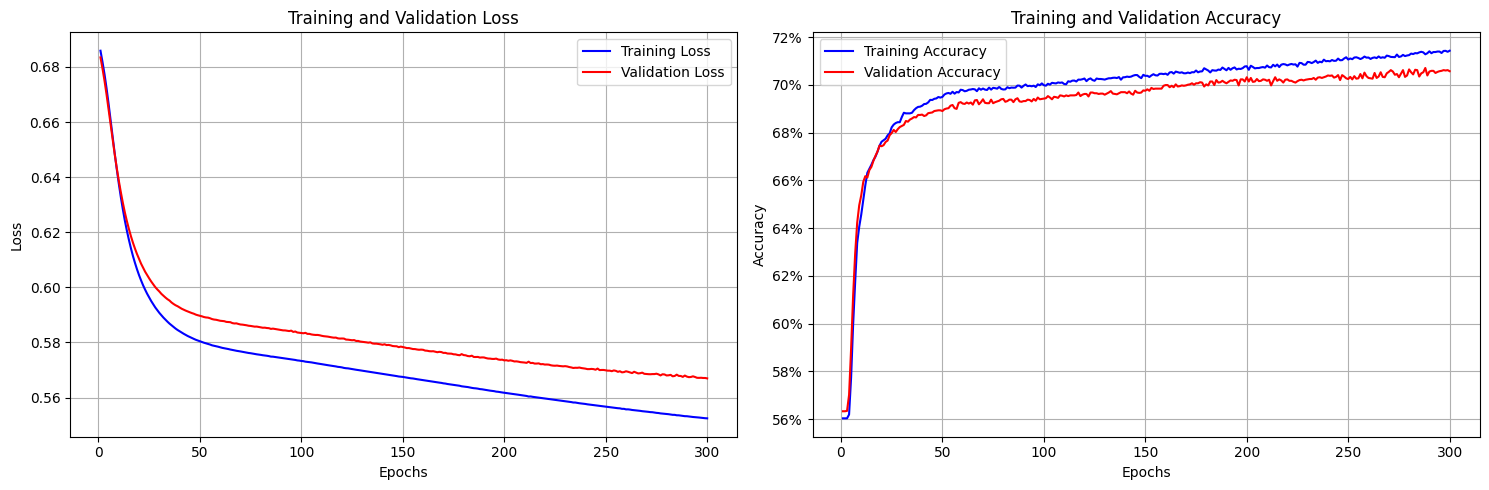

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(train_loss, train_acc, val_loss, val_acc):
    """
    Plot training and validation metrics on two subplots.

    Args:
        train_loss: Array of training loss values
        train_acc: Array of training accuracy values
        val_loss: Array of validation loss values
        val_acc: Array of validation accuracy values
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot epochs on x-axis
    epochs = range(1, len(train_loss) + 1)

    # First subplot: Loss
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Second subplot: Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Add accuracy percentage labels
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return fig

# Usage example:
plot_training_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)
plt.show()

In [32]:
def predict_sentences(model, sentences, vocab, max_len, device='cpu', threshold=0.5):
    """
    Make predictions for new sentences and interpret results
    """
    # Preprocess
    sequences = texts_to_sequences(sentences, vocab)
    padded = pad_sequences(sequences, max_len)
    #print(padded)

    # Convert to tensor
    input_ids = torch.tensor(padded, dtype=torch.long).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        print(outputs)
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (probabilities >= threshold).astype(int)

    # Print results
    for sentence, prob, pred in zip(sentences, probabilities, predictions):
        print(f"\nText: {sentence}")
        print(f"Probability: {prob:.4f}")
        print(f"Classification: {'Sarcastic' if pred == 1 else 'Not Sarcastic'}")
        print(f"Confidence: {max(prob, 1-prob):.4f}")
        print("-" * 80)

test_sentences = ["granny starting to fear spiders in the garden might be real",
             "game of thrones season finale showing this sunday night",
             "PyTorch book will be a best seller"]

# Example usage:
model = model.to(device)
predict_sentences(
    model=model,
    sentences=test_sentences,
    vocab=word_index,
    max_len=85,
    threshold=0.5  # Adjust this threshold if needed
)


tensor([[0.5137],
        [0.2067],
        [0.2858]])

Text: granny starting to fear spiders in the garden might be real
Probability: 0.5137
Classification: Sarcastic
Confidence: 0.5137
--------------------------------------------------------------------------------

Text: game of thrones season finale showing this sunday night
Probability: 0.2067
Classification: Not Sarcastic
Confidence: 0.7933
--------------------------------------------------------------------------------

Text: PyTorch book will be a best seller
Probability: 0.2858
Classification: Not Sarcastic
Confidence: 0.7142
--------------------------------------------------------------------------------


In [18]:
print(word_index)
print(texts_to_sequences(test_sentences, word_index))

{'new': 2, 'trump': 3, 'man': 4, 'not': 5, 'just': 6, 'will': 7, 'one': 8, 'year': 9, 'report': 10, 'area': 11, 'donald': 12, 'day': 13, 'u': 14, 's': 15, 'can': 16, 'says': 17, 'woman': 18, 'first': 19, 'time': 20, 'like': 21, 'no': 22, 'get': 23, 'old': 24, 'trumps': 25, 'off': 26, 'now': 27, 'life': 28, 'obama': 29, 'people': 30, 'house': 31, 'women': 32, 'white': 33, 'back': 34, 'still': 35, 'make': 36, 'clinton': 37, '5': 38, 'world': 39, 'americans': 40, 'years': 41, 'way': 42, 'family': 43, 'black': 44, 'study': 45, 'gop': 46, 'best': 47, 'bill': 48, 'american': 49, 'school': 50, 'police': 51, 'watch': 52, '3': 53, 'show': 54, 'really': 55, 'president': 56, 'home': 57, 'last': 58, 'video': 59, 'finds': 60, 'death': 61, 'cant': 62, 'know': 63, '10': 64, 'things': 65, 'good': 66, 'going': 67, 'state': 68, 'hillary': 69, 'love': 70, 'nation': 71, 'may': 72, '2': 73, 'health': 74, 'say': 75, 'parents': 76, 'big': 77, 'every': 78, 'right': 79, 'work': 80, '000': 81, 'need': 82, 'dead